# Random Forest

In [1]:
from preprocessing import *
from aux import *
import matplotlib
#np.warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado 1

In [2]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [3]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    features_a_encodear = ['nombre_sede','genero', 'tipo_de_sala']
    df = encodear_atributos_categoricos(df, features_a_encodear)
    df = df.reindex(columns = columnas)
    return df

In [4]:
volver = ['volveria']

In [5]:
columnas = columnillas + volver

In [6]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

In [7]:
df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,117,0,0,73.5,0,0,1,0,1,0,0,0
1,1,0,0,658,1,0,35.0,1,1,2,0,1,0,2,0
2,0,1,0,794,0,0,32.7,0,0,3,0,0,0,0,0
3,1,0,0,455,0,0,32.7,0,0,1,1,0,0,0,0
4,1,0,0,173,1,0,4.0,1,1,2,1,0,0,2,1


In [8]:
df.shape

(801, 15)

## Entrenamiento

In [9]:
X, y = split_dataset_X_y(df, columnillas)

params = {'max_samples': np.arange(1, 50),
          'min_samples_split': np.arange(2, 50),
          'max_features': np.arange(1, 13),
          'n_estimators': np.arange(1, 50),
          'criterion': ['gini', 'entropy']
         }

model_forest = RandomForestClassifier(random_state=117)

best_params, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, model_forest, params)

forest = RandomForestClassifier(random_state=117,
                                max_samples = best_params['max_samples'],
                                min_samples_split = best_params['min_samples_split'],
                                max_features = best_params['max_features'],
                                n_estimators= best_params['n_estimators'],
                                criterion= best_params['criterion'])

forest = apply_stratified_k_fold(X, y, forest)

X.shape:  (801, 14)
y.shape:  (801,) 

Best score: 0.8539071680376029
Best params {'n_estimators': 17, 'min_samples_split': 11, 'max_samples': 45, 'max_features': 12, 'criterion': 'entropy'}

Fold 0: AUC ROC score is 0.7397
Fold 1: AUC ROC score is 0.7566
Fold 2: AUC ROC score is 0.7760
Fold 3: AUC ROC score is 0.7906
Fold 4: AUC ROC score is 0.7694
Mean test AUC ROC is: 0.7665


## Métricas

In [10]:
scores = get_scores(forest, X_test, y_test)

AUC ROC : 0.8500
Accuracy : 0.7413
Precision : 0.6866
Recall : 0.8306
F1-Score : 0.6389


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


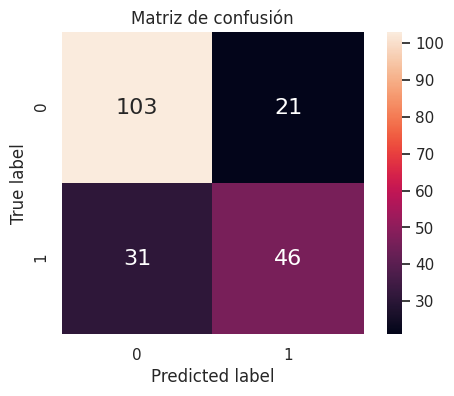

In [11]:
plot_confusion_matrix(y_test, forest.predict(X_test))

## Test Holdout

In [12]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [13]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,650,1,0,26.0,0,0,1,1,0,0,0
1,1,0,0,234,1,0,8.0,4,2,4,1,0,0,6
2,0,1,0,31,0,0,43.0,0,0,3,0,0,0,0
3,0,0,0,552,0,0,30.0,0,0,3,1,0,0,0
4,1,0,0,411,0,0,32.8,0,0,1,1,0,0,0


In [14]:
df_resultado = evaluate_holdout(holdout, df_h, forest)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,0
1,234,1
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,1
9,112,1


In [15]:
df_resultado.to_csv('prediccion/random_forest_resultado_final.csv')

## Preprocesado 2

In [107]:
columnas_nuevas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 
                   'amigos', 'parientes', 
                   'precio_ticket', 
                   'fila_medio', 'fila_nan',
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']
columnas_2 = columnas_nuevas + volver

In [108]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, False)
    df = replace_nulls_column(df, 'edad', 'mediana')
    features_a_encodear = ['nombre_sede','genero', 'tipo_de_sala', 'fila']
    df = encodear_atributos_categoricos(df, features_a_encodear)
    df = normalizar_atributos_numericos(df)
    df = df.reindex(columns = columnas)
    return df

In [109]:
df_2 = preprocesado_2(dataset, columnas_2)
df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,1,0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,1,0,0.0
2,0,1,0,0.891011,0,0,0.346734,0.000,0.000000,0.040816,0,1,0,0,0,0.0
3,1,0,0,0.510112,0,0,0.346734,0.000,0.000000,0.000000,0,1,1,0,0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,0,1,1,0,0,1.0


In [110]:
df_2.shape

(801, 16)

# Entrenamiento

In [111]:
X_2, y_2 = split_dataset_X_y(df_2, columnas_nuevas)

params_2 = {'max_samples': np.arange(1, 50),
          'min_samples_split': np.arange(2, 50),
          'max_features': np.arange(1, 14),
          'n_estimators': np.arange(1, 50),
          'criterion': ['gini', 'entropy']
         }

model_forest = RandomForestClassifier(random_state=117)

best_params_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, model_forest,
                                                                                        params_2)

forest_2 = RandomForestClassifier(random_state=117,
                                max_samples = best_params_2['max_samples'],
                                min_samples_split = best_params_2['min_samples_split'],
                                max_features = best_params_2['max_features'],
                                n_estimators= best_params_2['n_estimators'],
                                criterion= best_params_2['criterion'])

forest_2 = apply_stratified_k_fold(X_2, y_2, forest_2)

X.shape:  (801, 15)
y.shape:  (801,) 

Best score: 0.8570799059929495
Best params {'n_estimators': 27, 'min_samples_split': 17, 'max_samples': 39, 'max_features': 4, 'criterion': 'gini'}

Fold 0: AUC ROC score is 0.7195
Fold 1: AUC ROC score is 0.7931
Fold 2: AUC ROC score is 0.7760
Fold 3: AUC ROC score is 0.7899
Fold 4: AUC ROC score is 0.7702
Mean test AUC ROC is: 0.7698


## Métricas

In [112]:
scores_2 = get_scores(forest_2, X_test_2, y_test_2)

AUC ROC : 0.8479
Accuracy : 0.7761
Precision : 0.7162
Recall : 0.8306
F1-Score : 0.7020


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


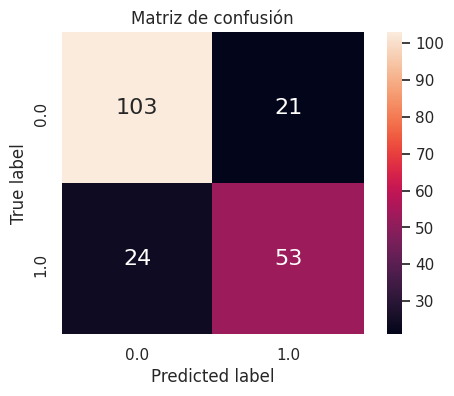

In [113]:
plot_confusion_matrix(y_test_2, forest_2.predict(X_test_2))

## Test Holdout

In [114]:
df_h_2 = preprocesado_2(holdout, columnas_nuevas)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,0,1,1,0,0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,0,1,1,0,0
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,1,0,0,0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,0,1,1,0,0
4,1,0,0,0.471897,0,0,0.438378,0.0,0.0,0.000000,0,1,1,0,0


In [115]:
df_resultado_2 = evaluate_holdout(holdout, df_h_2, forest_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 15) 



,id_usuario,volveria
0,650,0
1,234,1
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,1
9,112,1


In [116]:
df_resultado_2.to_csv('prediccion/random_forest_2do_prepoc_resultado_final.csv')